In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr

In [3]:
az.style.use("arviz-whitegrid")
plt.rc('figure', dpi=450)

In [4]:
configs = [
    {"true_mu": 0.9, "sigma": 1,   "size":  50, "seed": 1},
    {"true_mu": 0.7, "sigma": 1,   "size":  50, "seed": 4},
    {"true_mu": 0.0, "sigma": 1,   "size":  50, "seed": 2},
    {"true_mu": 0.2, "sigma": 1,   "size":  50, "seed": 5},
    {"true_mu": 0.25, "sigma": 1,   "size": 500, "seed": 3},
    {"true_mu": 0.0, "sigma": 3,   "size":  50, "seed": 6},
]

idatas = []
for cfg in configs:
    # 1) Simulate data
    np.random.seed(cfg["seed"])
    data = np.random.normal(cfg["true_mu"], cfg["sigma"], size=cfg["size"])
    
    # 2) Build & sample PyMC model
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=10)
        pm.Normal("obs", mu=mu, sigma=cfg["sigma"], observed=data)
        idata = pm.sample(
            draws=1000,
            tune=1000,
            chains=2,
            cores=1,
            random_seed=cfg["seed"],
            return_inferencedata=True,
            progressbar=False
        )
    
    idatas.append(idata)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sequential sampling (2 chains in 1 job)
NUTS: [mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of conver

C:\Users\ASUS\AppData\Local\Temp\ipykernel_40588\1190370881.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_40588\1190370881.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.05, 1, 1])


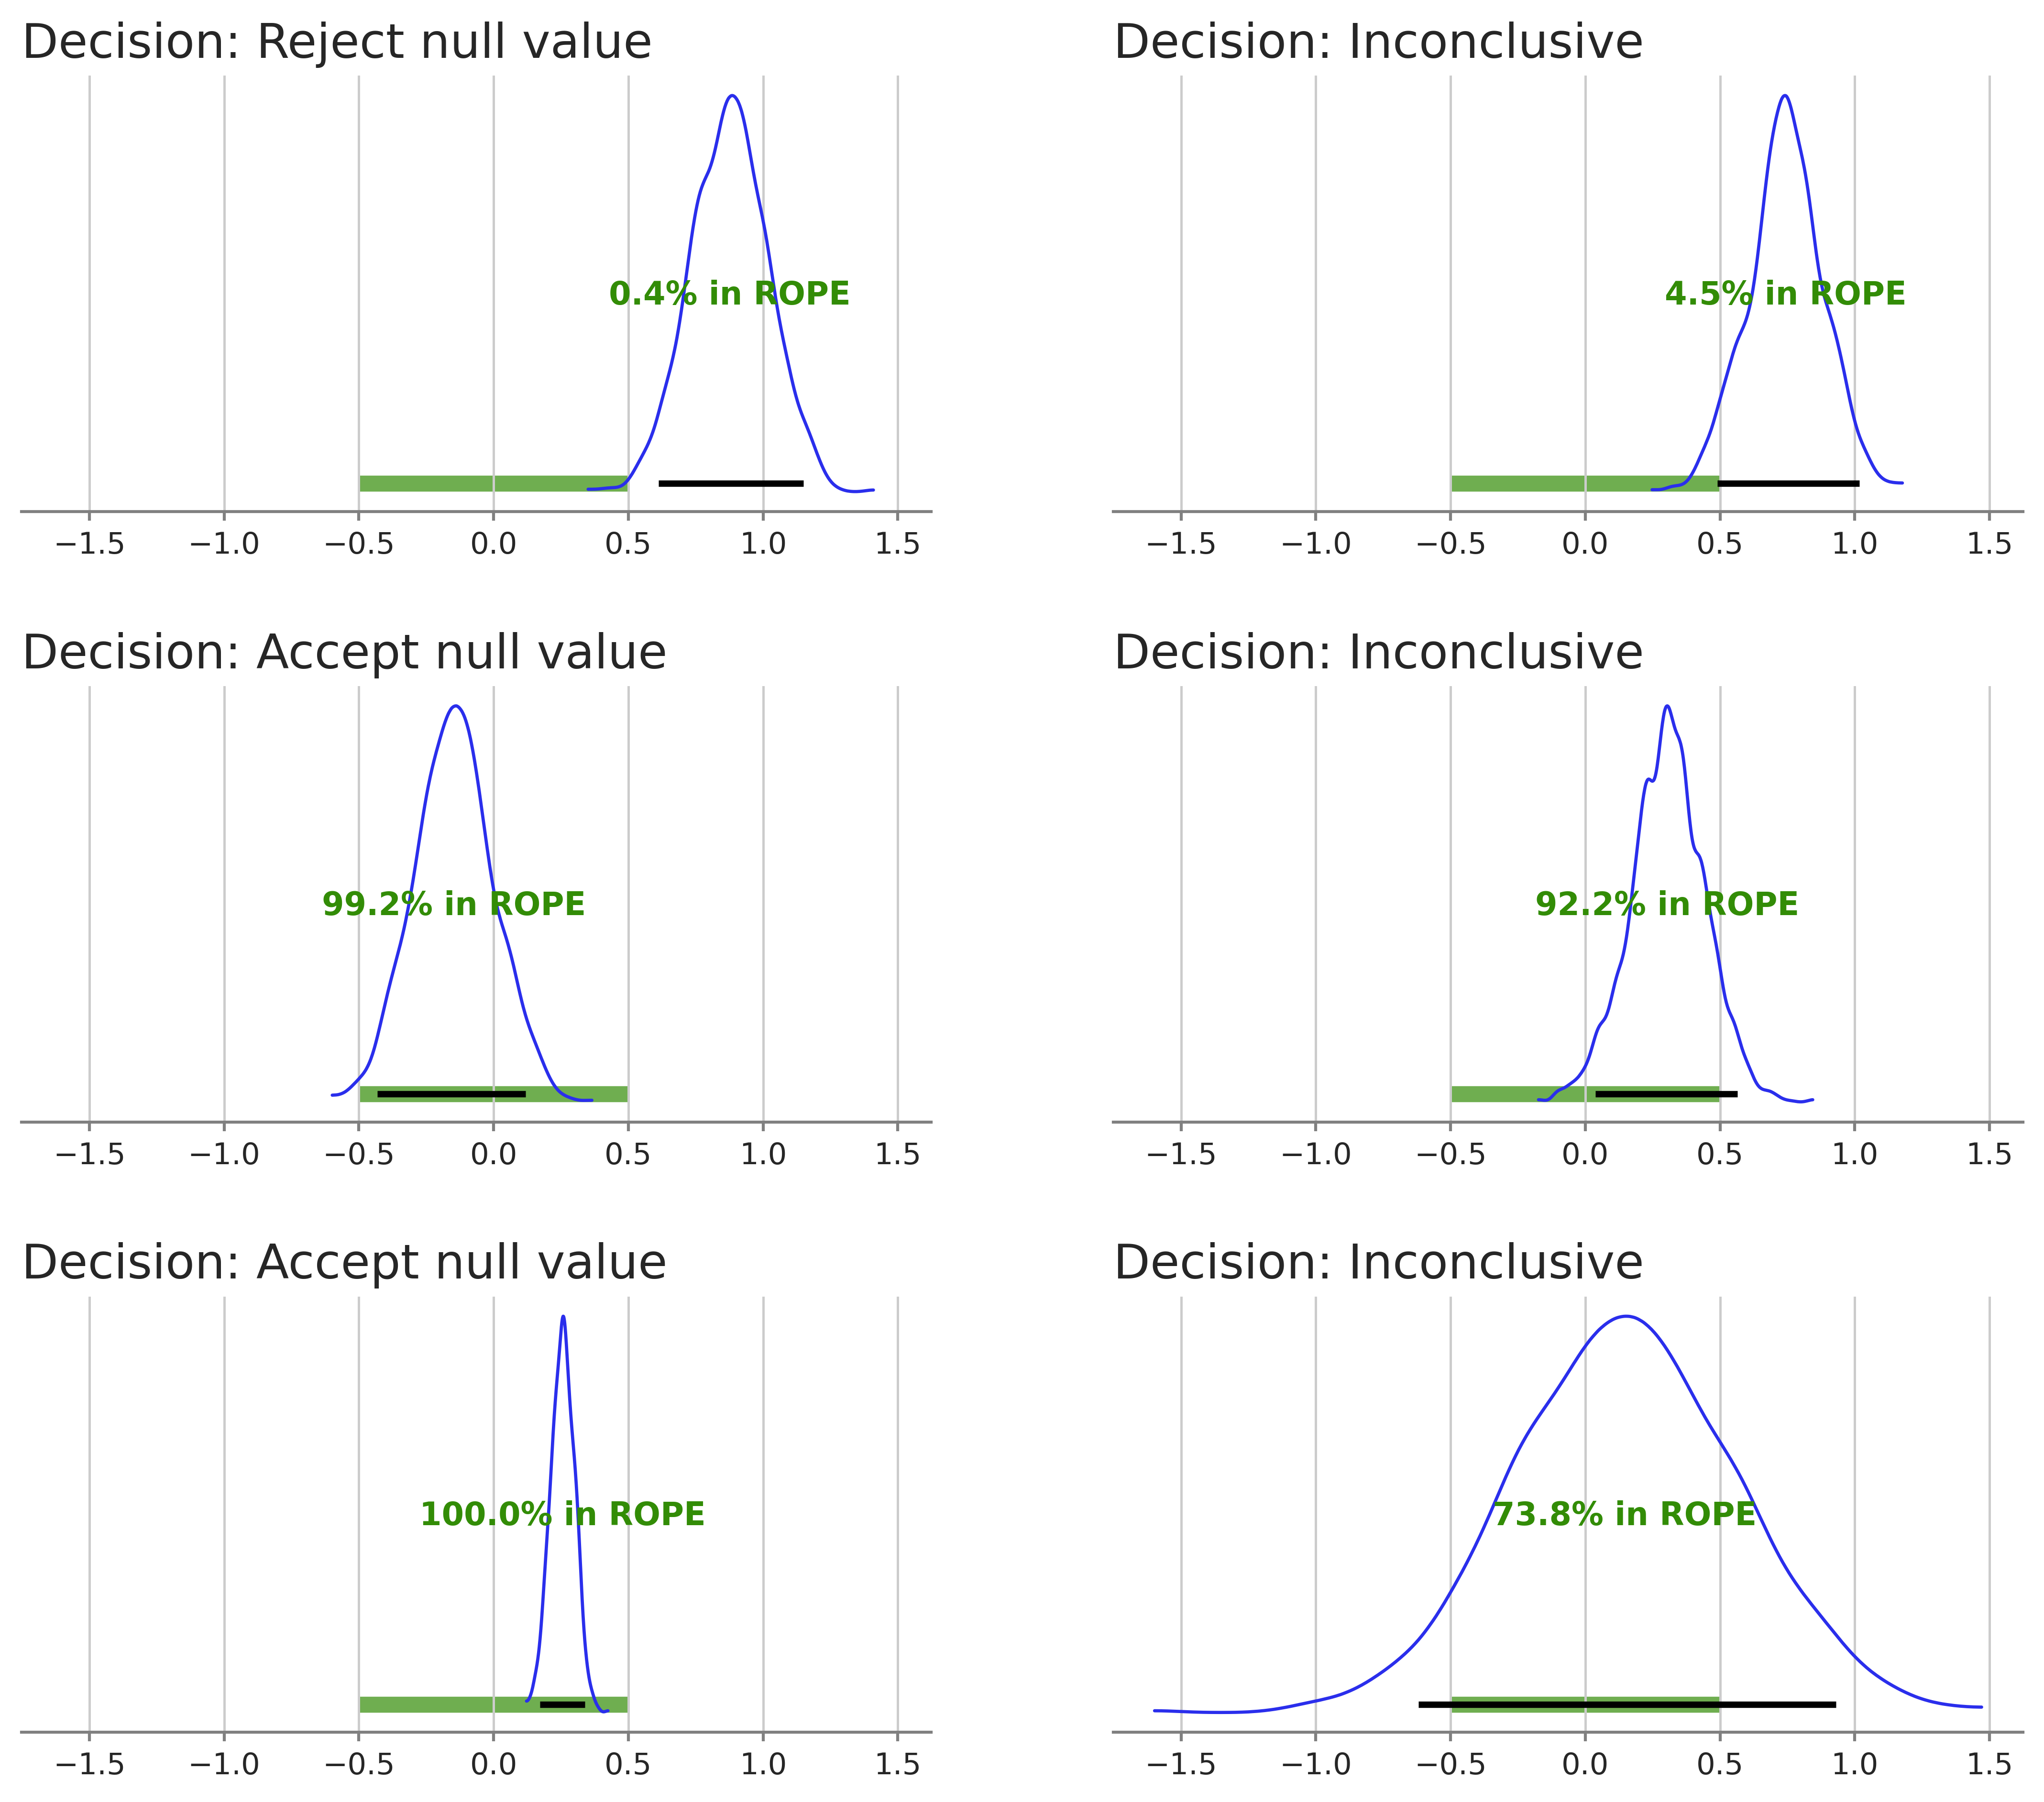

In [5]:
# ROPE and null-value
rope     = (-0.5, +0.5)
ref_val  =  0.0
hdi_prob =  0.94

# Set up 3×2 grid
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True, gridspec_kw={'wspace': 0.2, 'hspace': 0.4})
axes = axes.flatten()

for ax, idata in zip(axes, idatas):
    # 3) Plot posterior with ArviZ
    az.plot_posterior(
        idata,
        var_names=["mu"],
        ax=ax,
        rope=rope,
        hdi_prob=hdi_prob,
        textsize=10,
        round_to=2,
        point_estimate=None,
        ref_val=None
    )
    
    for txt in ax.texts:
        # keep only the ones mentioning "in ROPE"
        if "in ROPE" not in txt.get_text():
            txt.remove()

    hdi = az.hdi(idata, var_names=["mu"], hdi_prob=hdi_prob)
    hdi_lower = hdi.sel(hdi="lower")["mu"].values
    hdi_upper = hdi.sel(hdi="higher")["mu"].values
    rope_lower, rope_upper = rope

    decision = "Inconclusive"
    if rope_lower < hdi_lower and hdi_upper < rope_upper:
        decision = "Accept null value"
    elif hdi_upper < rope_lower or rope_upper < hdi_lower:  
        decision = "Reject null value"

    # 4) Title
    ax.set_title("", pad=0)
    ax.set_title(f"Decision: {decision}", loc="left")

# Common X-axis label
# fig.text(0.5, 0.04, "Parameter Value", ha="center")
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [6]:

hdi_lower = 1.5
hdi_upper = 2.5
print([hdi_lower, hdi_upper, rope_lower, rope_upper])

decision = "Inconclusive"
if (rope_lower < hdi_lower) and (hdi_upper < rope_upper):
    decision = "Accept null value"
elif (hdi_upper < rope_lower) or (rope_upper < hdi_lower):  
    decision = "Reject null value"

print(decision)

[1.5, 2.5, -0.5, 0.5]
Reject null value


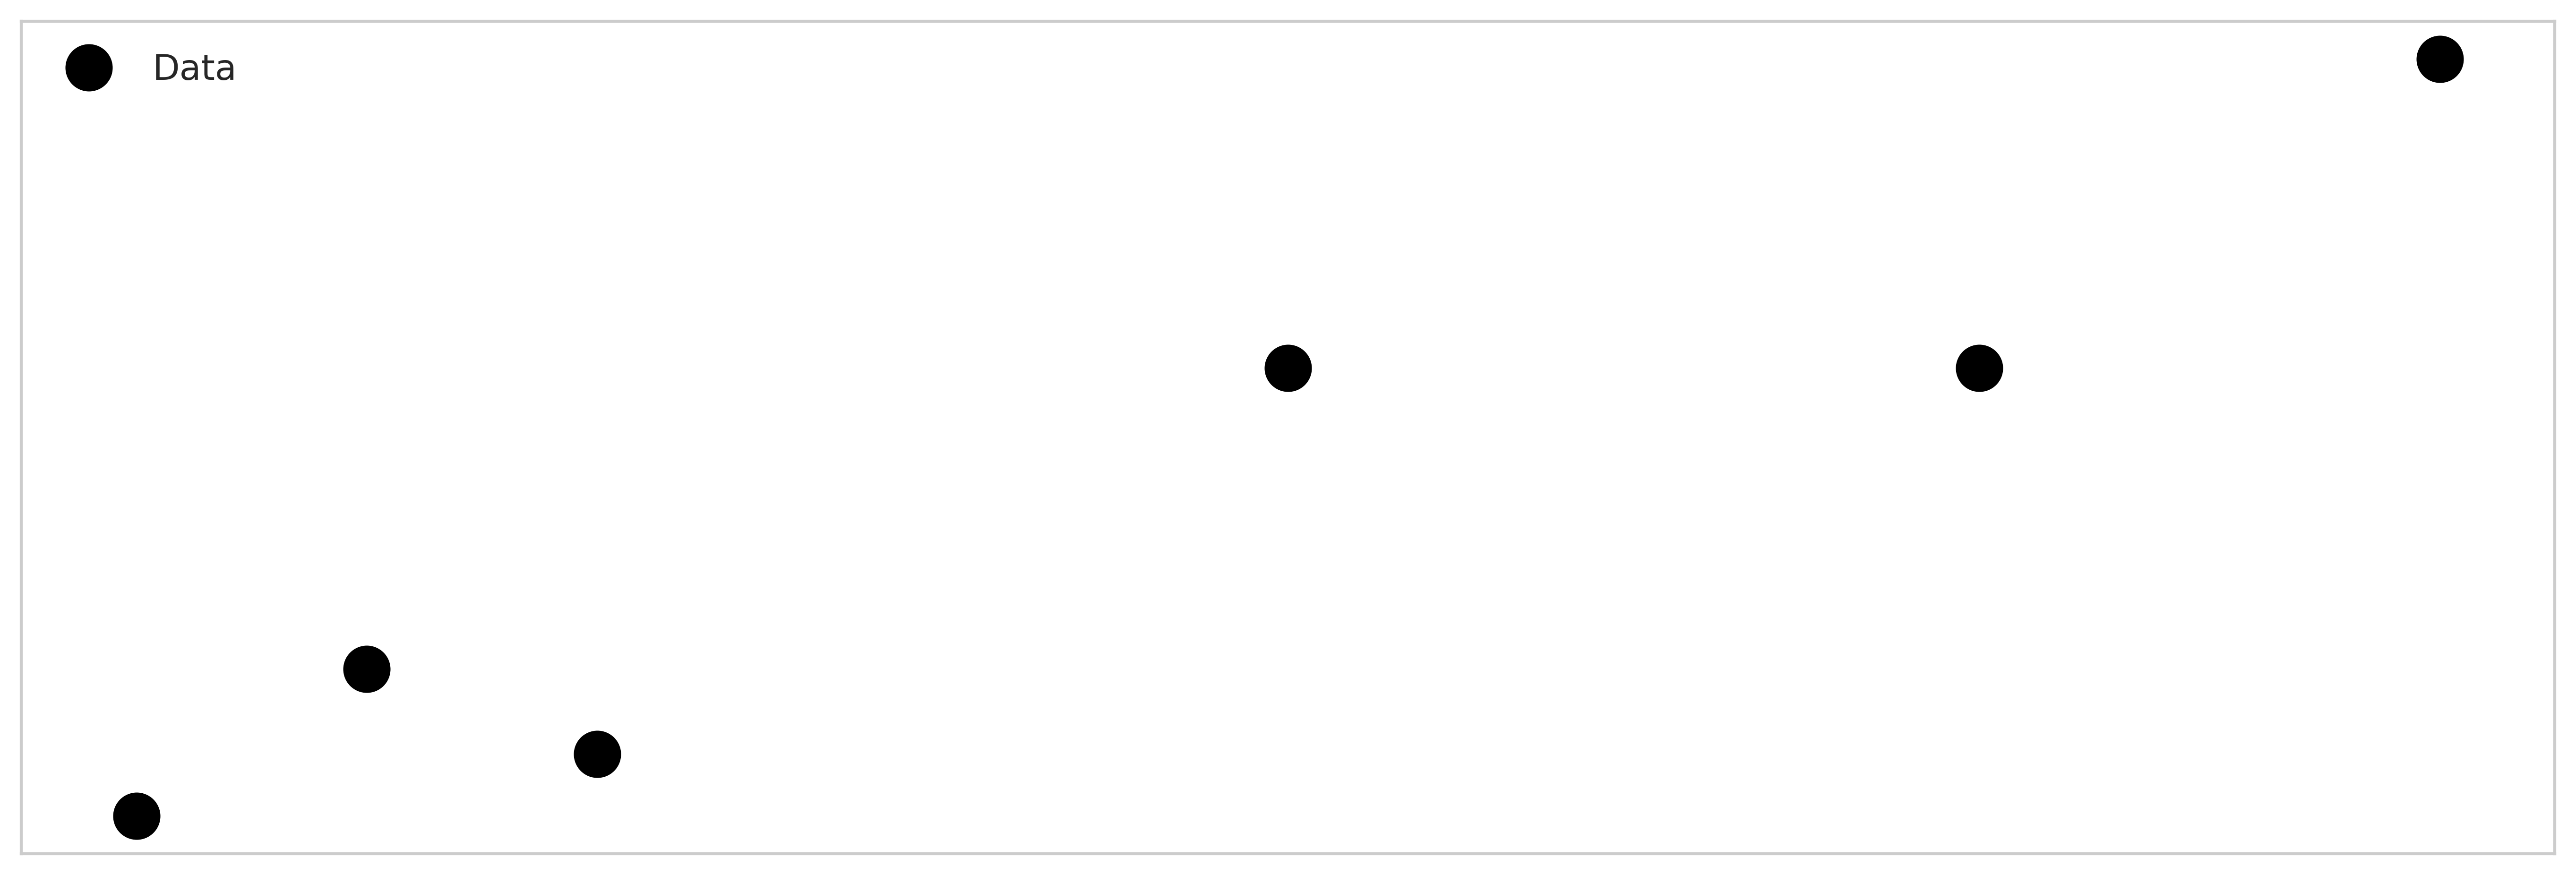

In [7]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])

order = [0, 1, 5]
ax.plot(x0, y0, "ko", zorder=3, markersize=15, label="Data")

ax.set_yticks([])
ax.set_xticks([])

ax.legend(loc=2, fontsize=12)

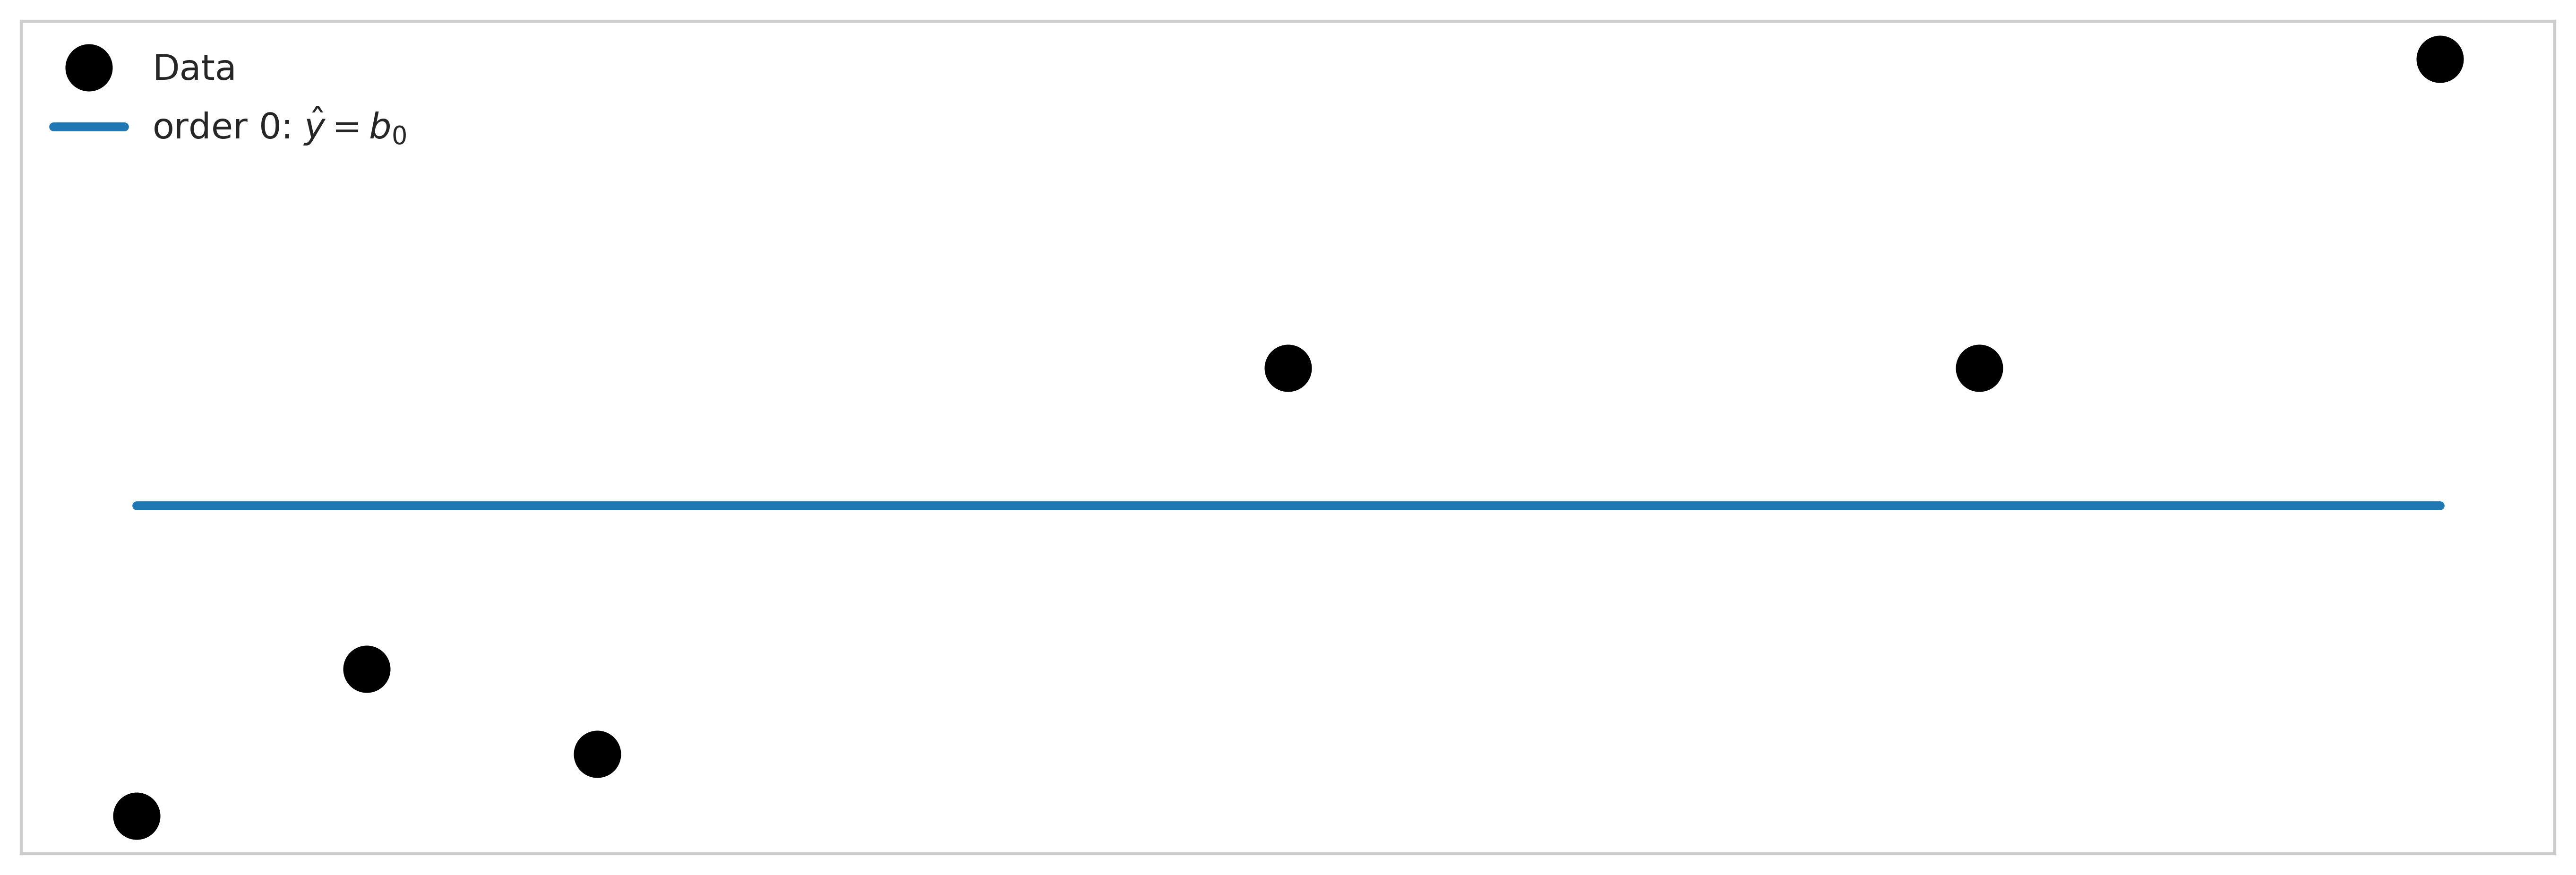

In [8]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

order = [0]
order_label = [r'$\hat{y} = b_0$']
order_colors = ["#1f77b4"]

ax.plot(x0, y0, "ko", zorder=3, markersize=15, label="Data")


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i in order:
    p = np.polynomial.Polynomial.fit(x0, y0, deg=i)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)

    ax.plot(x_n, p(x_n), color=order_colors[i], label=f"order {i}: {order_label[i]}", lw=3)


ax.legend(loc=2, fontsize=12)

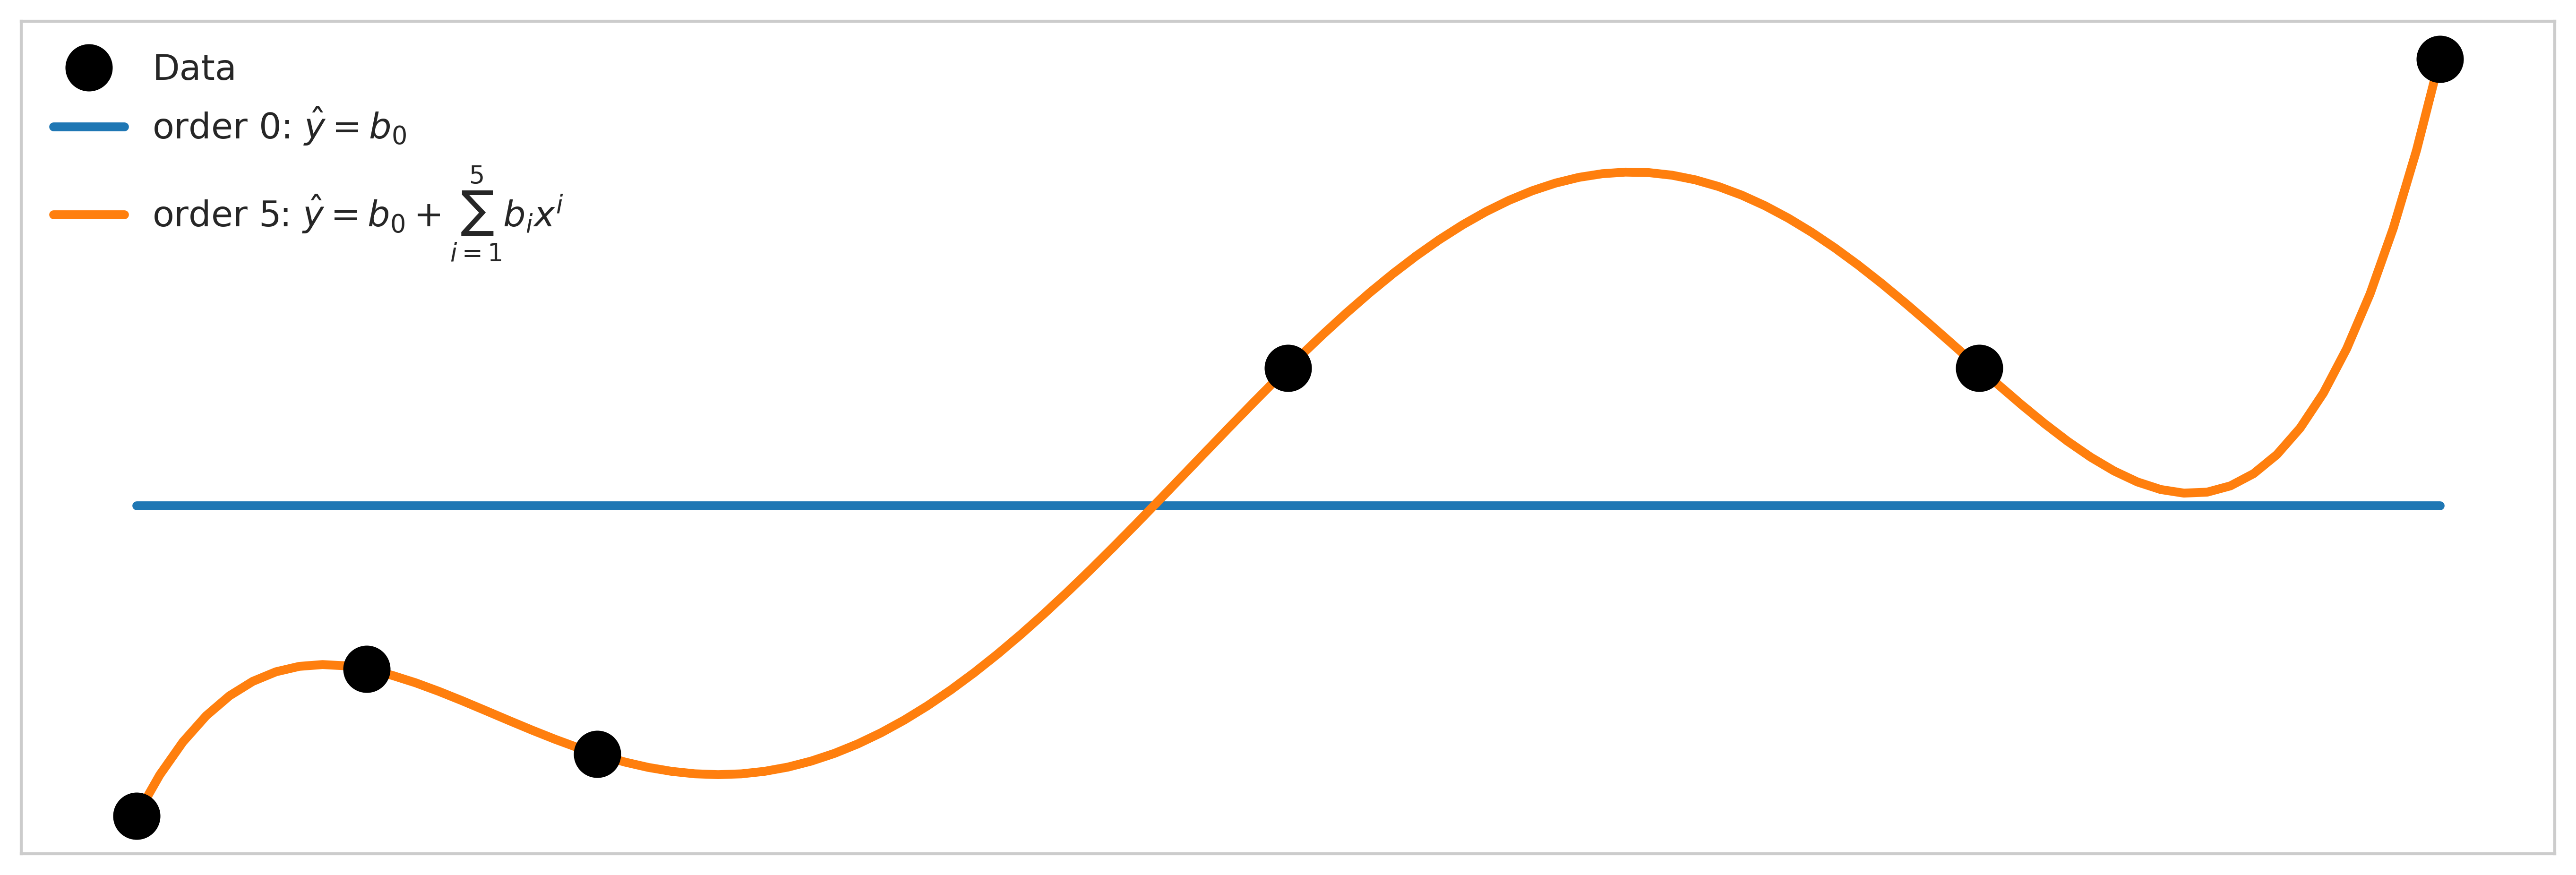

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

order = [0, 5]
order_label = [r'$\hat{y} = b_0$', r'$\hat{y} = b_0 + \sum_{i=1}^{5} b_i x^i$']
order_colors = ["#1f77b4", "#ff7f0e"]

ax.plot(x0, y0, "ko", zorder=3, markersize=15, label="Data")


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i,o in enumerate(order):
    p = np.polynomial.Polynomial.fit(x0, y0, deg=o)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)

    ax.plot(x_n, p(x_n), color=order_colors[i], label=f"order {o}: {order_label[i]}", lw=3)


ax.legend(loc=2, fontsize=12)

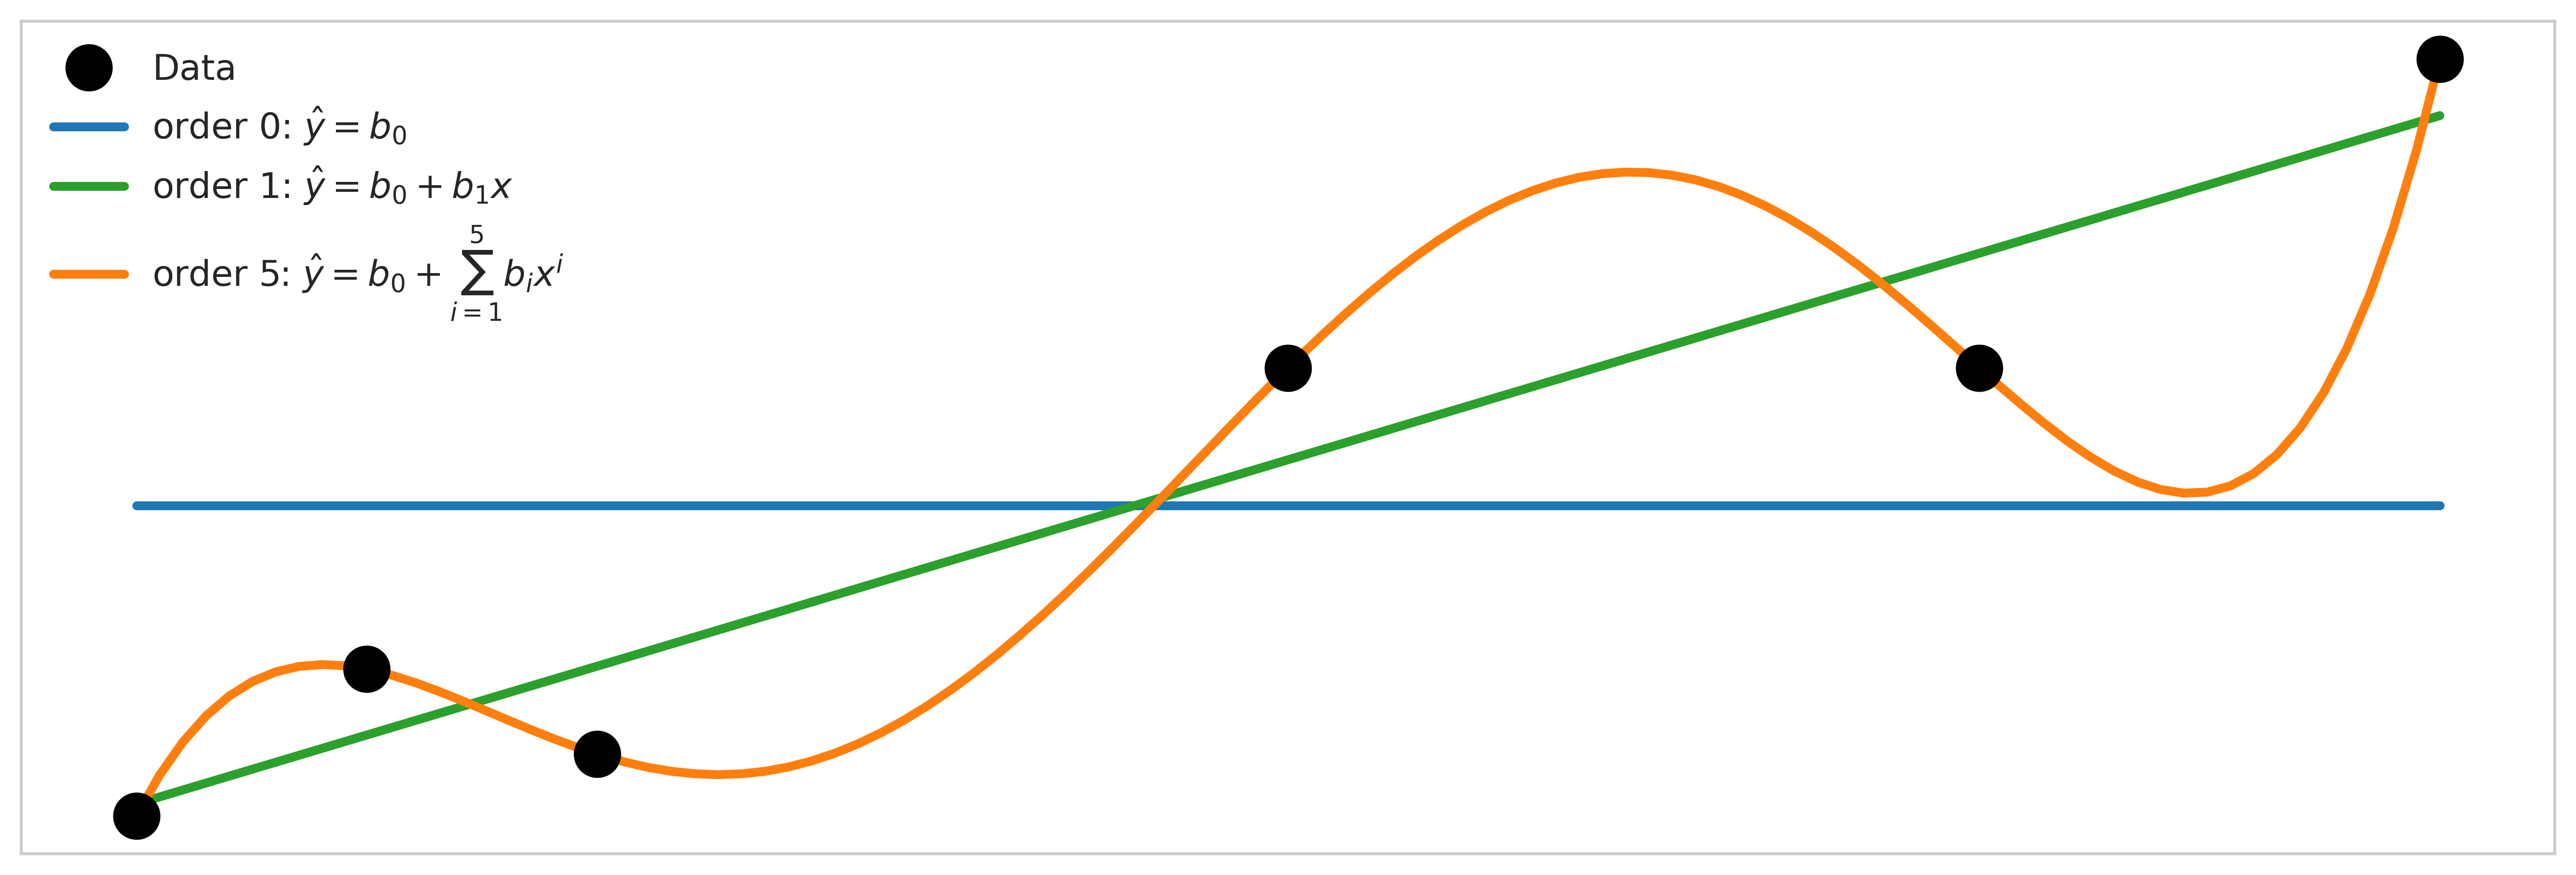

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))

order = [0, 1, 5]
order_label = [r'$\hat{y} = b_0$', r'$\hat{y} = b_0 + b_1 x$', r'$\hat{y} = b_0 + \sum_{i=1}^{5} b_i x^i$']
order_colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]

ax.plot(x0, y0, "ko", zorder=3, markersize=15, label="Data")


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i,o in enumerate(order):
    p = np.polynomial.Polynomial.fit(x0, y0, deg=o)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)

    ax.plot(x_n, p(x_n), color=order_colors[i], label=f"order {o}: {order_label[i]}", lw=3)


ax.legend(loc=2, fontsize=12)

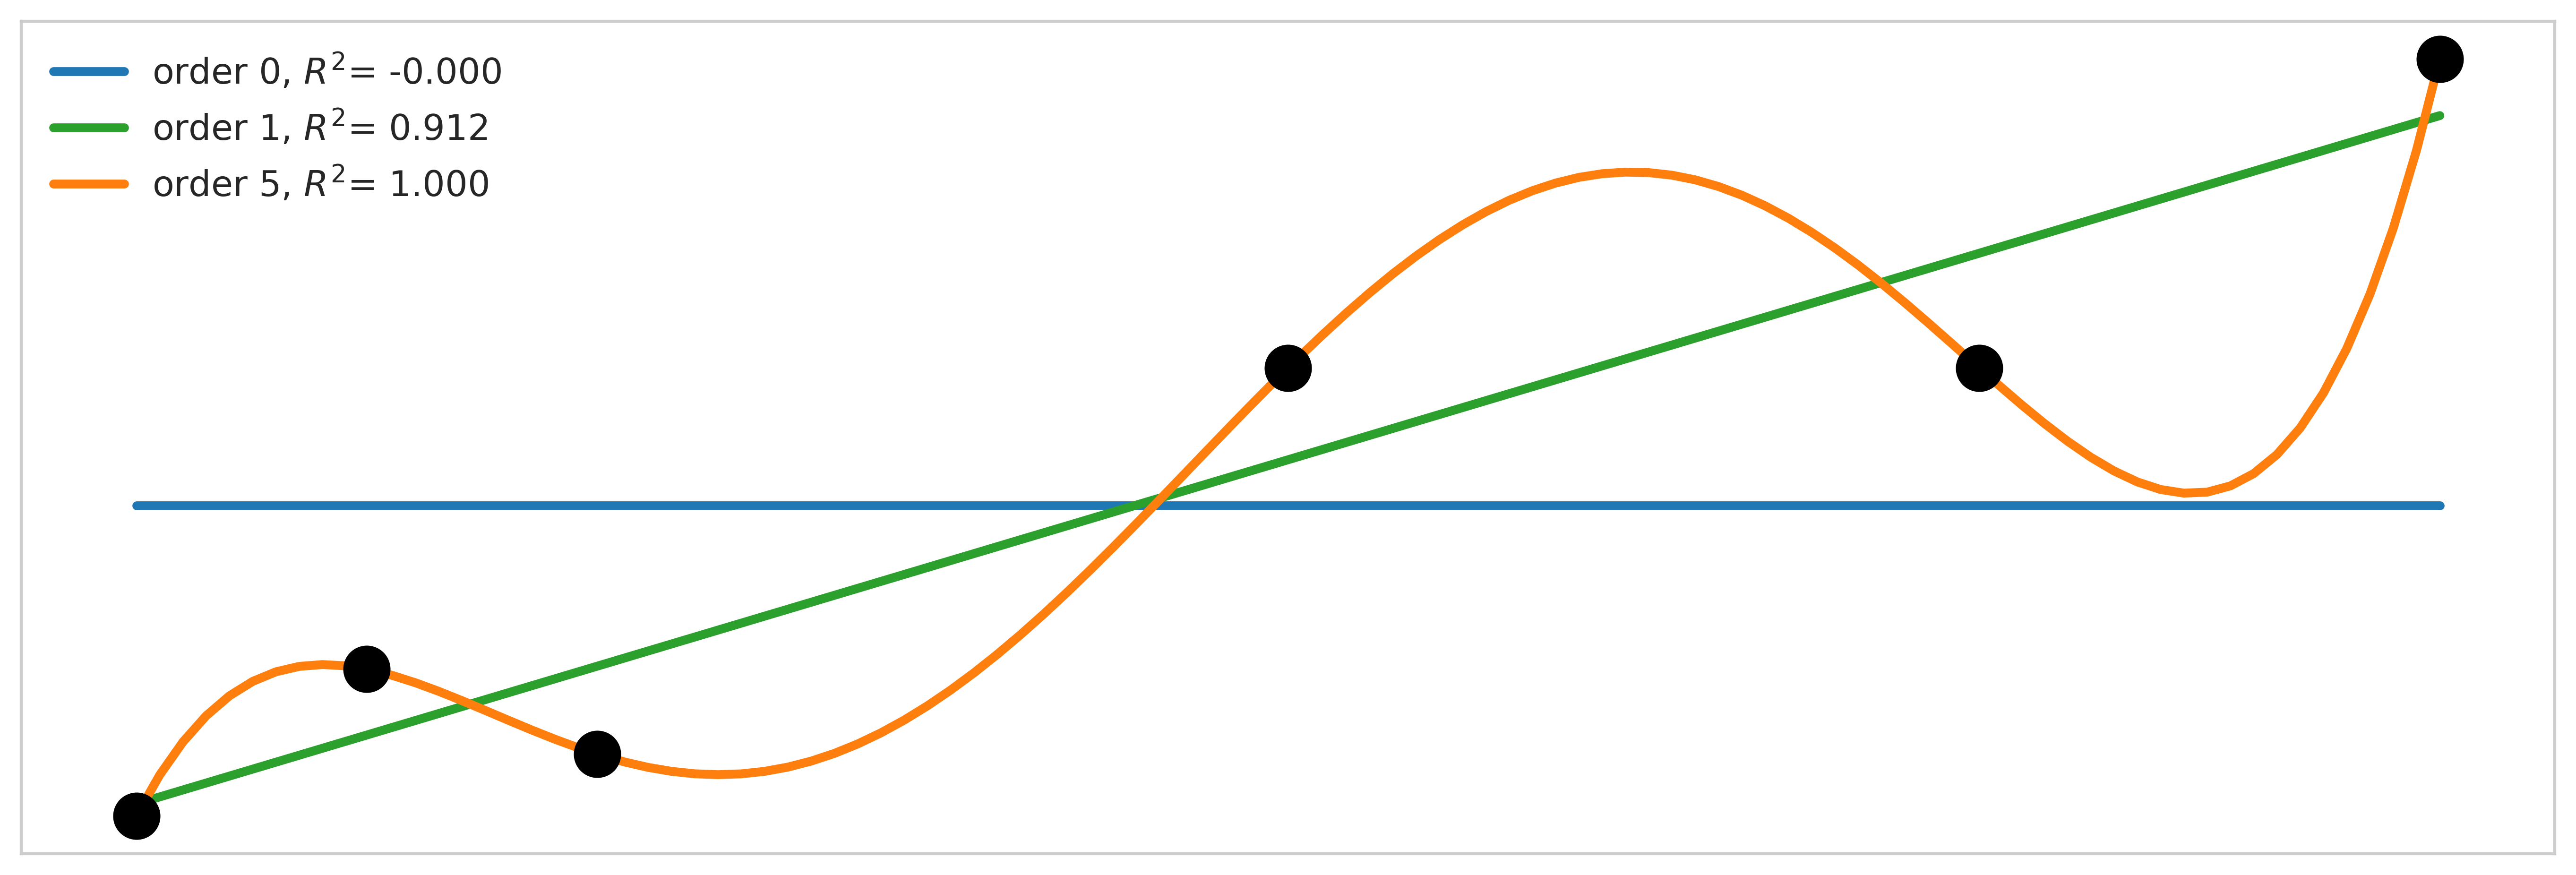

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))


x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])

order = [0, 1, 5]
order_colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]
ax.plot(x0, y0, "ko", markersize=15, zorder=3)


ax.set_yticks([])
ax.set_xticks([])

x_n = np.linspace(x0.min(), x0.max(), 100)
ps = []
for i,o in enumerate(order):
    p = np.polynomial.Polynomial.fit(x0, y0, deg=o)
    ps.append(p)
    yhat = p(x0)
    ybar = np.mean(y0)
    ss_regression = np.sum((yhat - y0) ** 2)
    ss_total = np.sum((ybar - y0) ** 2)
    r2 = 1 - ss_regression / ss_total
    ax.plot(x_n, p(x_n), color=order_colors[i], label=f"order {o}, $R^2$= {r2:.3f}", lw=3)


ax.legend(loc=2, fontsize=12)

c:\Git-projects\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Git-projects\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Git-projects\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Git-projects\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\numpy\polynomial\polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Git-projects\StatisticalComputationAndAnalysis\.pixi\envs\default\Lib\site-packages\numpy

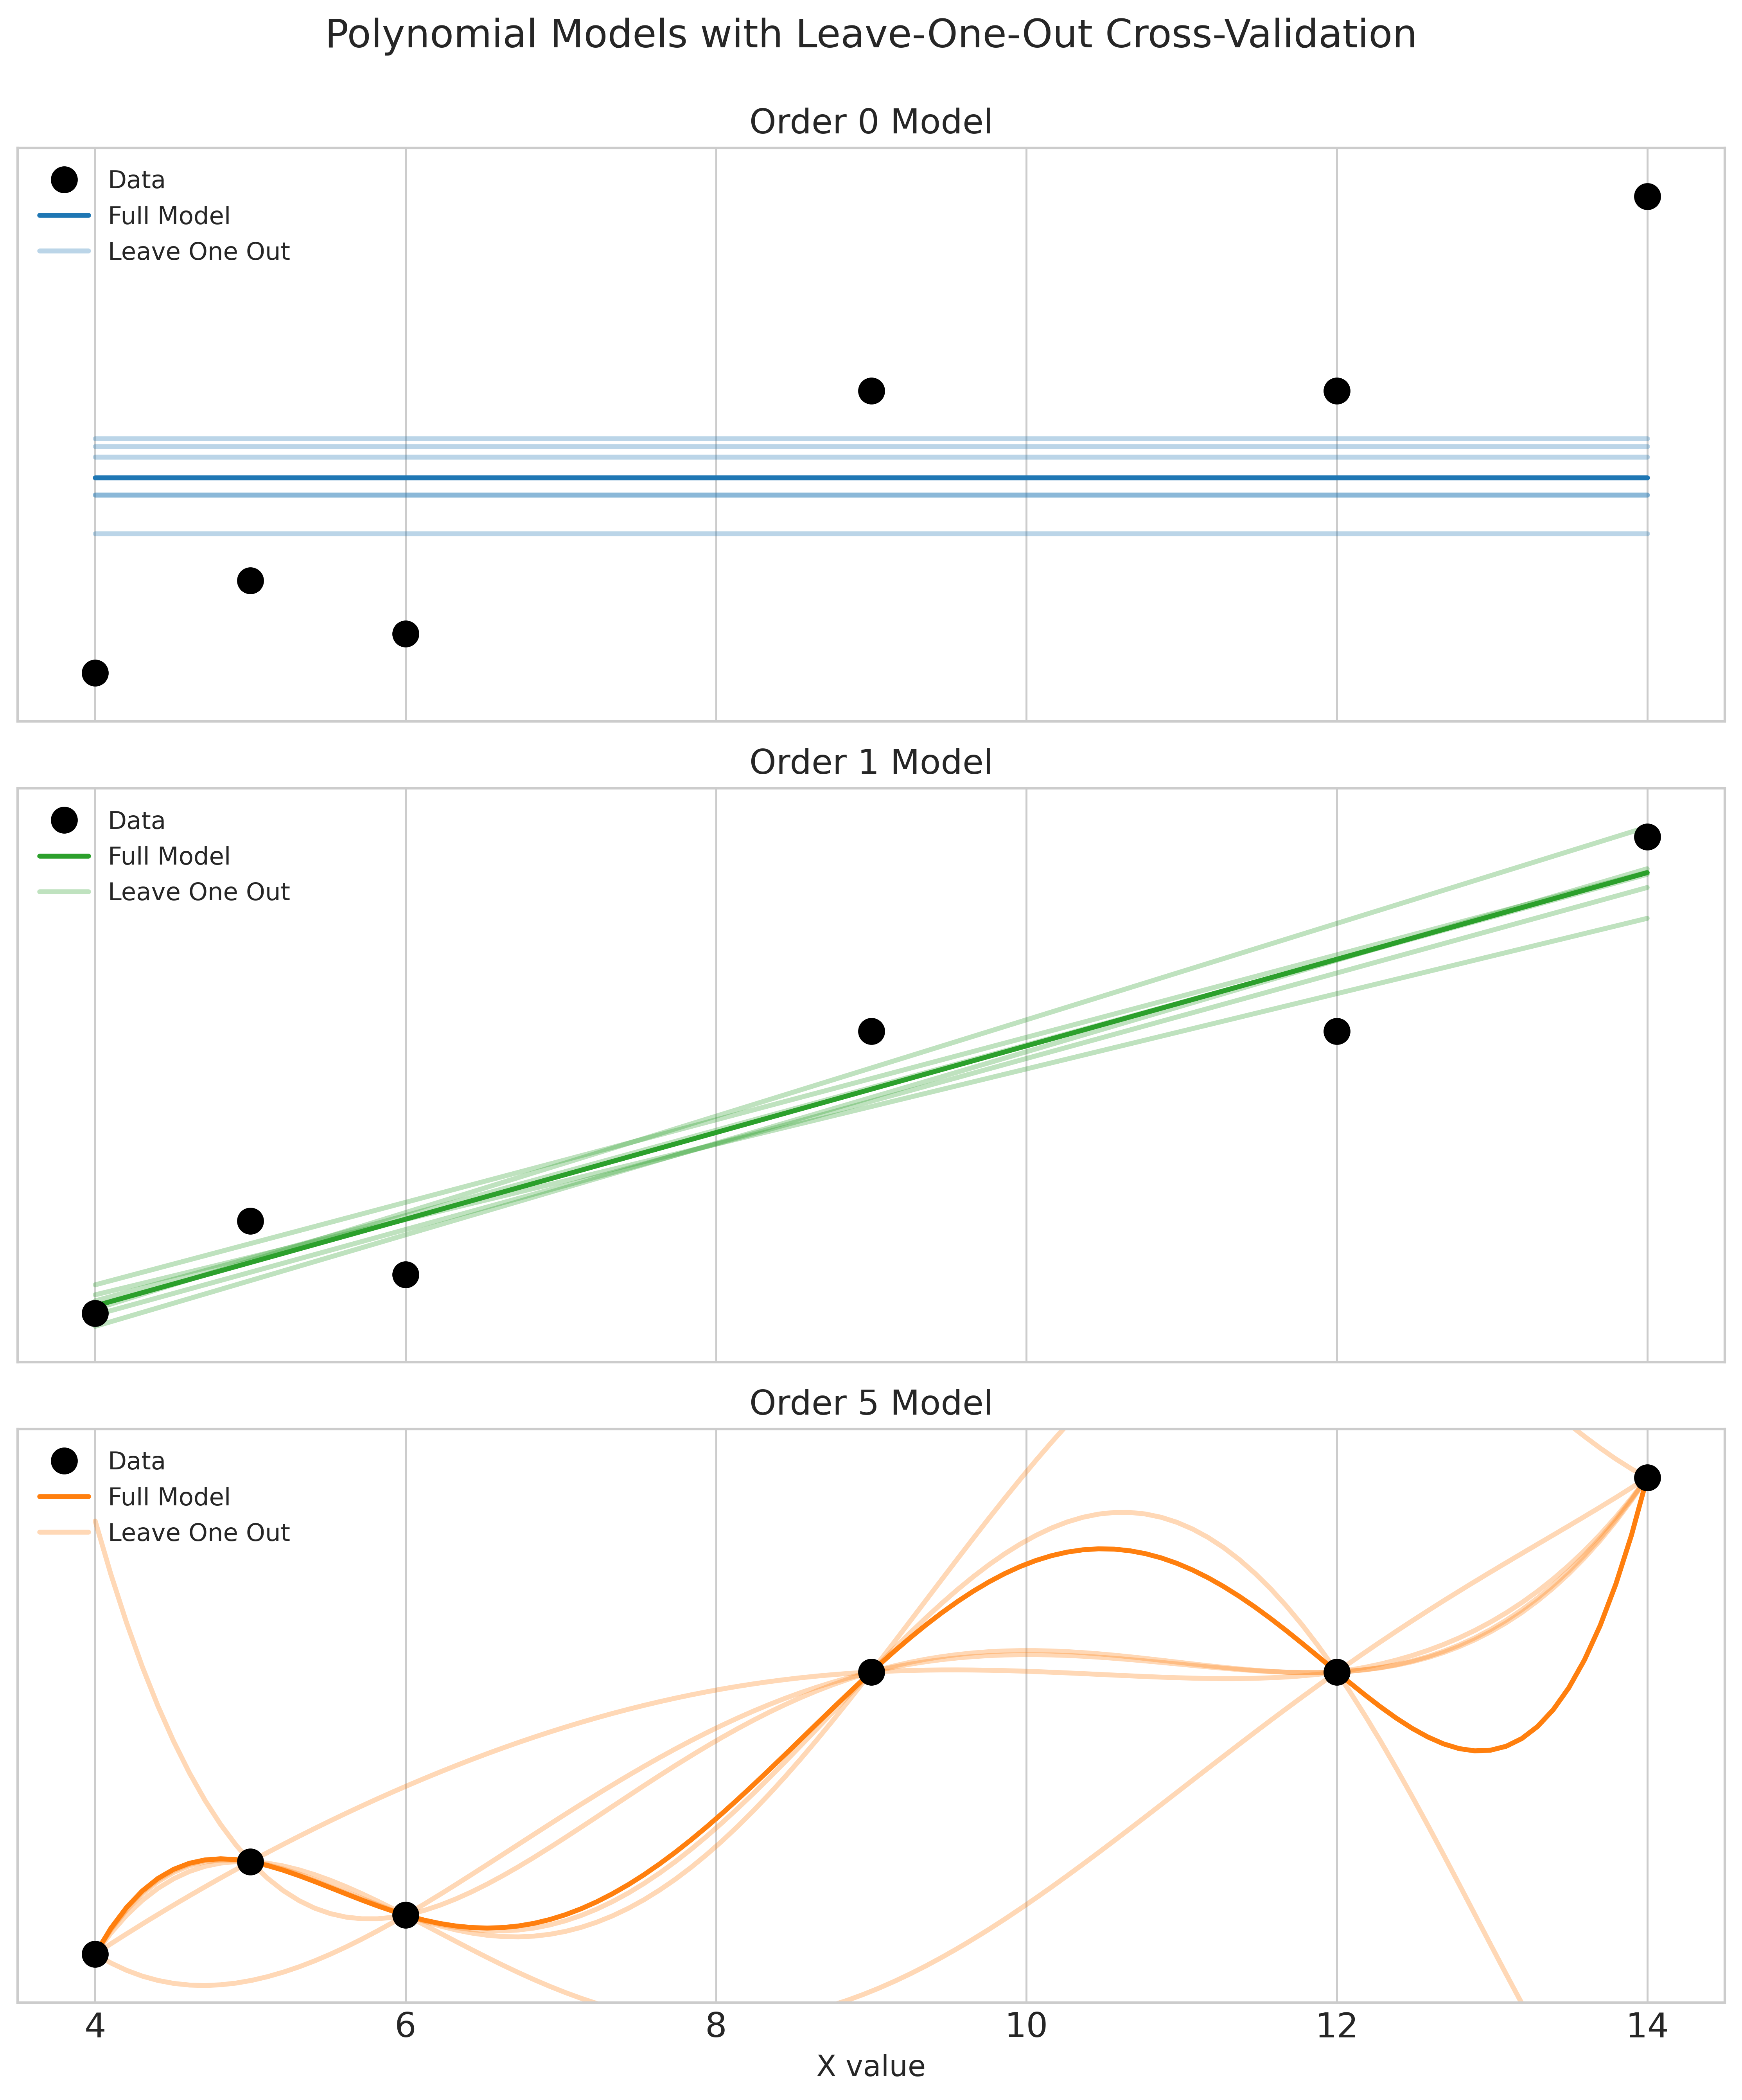

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

x0 = np.array([4.0, 5.0, 6.0, 9.0, 12, 14.0])
y0 = np.array([4.2, 6.1, 5.0, 10.0, 10, 14.0])
n_points = len(x0)

order_values = [0, 1, 5]
order_colors = ["#1f77b4", "#2ca02c", "#ff7f0e"]

x_n = np.linspace(x0.min(), x0.max(), 100)

for idx, (ax, current_order) in enumerate(zip(axes, order_values)):
    color = order_colors[idx]
    ax.plot(x0, y0, "ko", markersize=10, zorder=3, label="Data")

    ax.set_yticks([])
    ax.set_xticks([]) # Keep for top/middle, will be overridden by sharex for bottom if needed
    ax.set_title(f"Order {current_order} Model", fontsize=14)

    # Fit and plot the model on all data
    p_full = np.polynomial.Polynomial.fit(x0, y0, deg=current_order)
    ax.plot(x_n, p_full(x_n), color=color, label="Full Model", lw=2, zorder=2)

    # Fit and plot LOO models
    for k in range(n_points):
        x_loo = np.delete(x0, k)
        y_loo = np.delete(y0, k)
        
        p_loo = np.polynomial.Polynomial.fit(x_loo, y_loo, deg=current_order)
        # Label only the first LOO line
        loo_label = "Leave One Out" if k == 0 else None
        ax.plot(x_n, p_loo(x_n), color=color, lw=2, alpha=0.3, zorder=1, label=loo_label)

    ax.legend(loc="best", fontsize=10)
    ax.set_ylim([min(y0)-1, max(y0)+1]) # Consistent y-limits for better comparison

if axes.shape[0] > 0: # Set x-label only for the bottom-most plot if plots exist
   axes[-1].set_xticks(np.arange(x0.min(), x0.max()+1, 2)) # Example ticks
   axes[-1].set_xlabel("X value", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle if added
fig.suptitle("Polynomial Models with Leave-One-Out Cross-Validation", fontsize=16, y=0.99)
plt.show()